# Pre-process VESPA Dataset

**Publication**: George Rosenberger et al. Network-based elucidation of colon cancer drug resistance mechanisms by phosphoproteomic time-series analysis

In [1]:
import pandas as pd
import numpy as np
import os

import plotnine as p9
import matplotlib.pyplot as plt
from matplotlib_venn import venn2
import seaborn as sns

import statsmodels.formula.api as smf
from sklearn.impute import KNNImputer
from sklearn.decomposition import PCA

## Load & format data

Data are loaded and split into two dataframes. `map_protein` contains all the information to map the phosphosites to the peptides, proteins and genes. `phospho_data` have the phosphopeptide measurements and the experiment metadata. Time is also processed to convert hours to minutes.

In [ ]:
file_path = os.path.join('..', 'data_raw', 'VESPA', 'U54_COAD_phospho.csv')
vespa_df = pd.read_csv(file_path)

In [ ]:
# Split the DataFrame into map_protein and phospho_data
map_protein = vespa_df[['site_id', 'gene_id', 'protein_id', 'peptide_id', 'modified_peptide_sequence', 'peptide_sequence', 'phosphosite']].drop_duplicates(subset='site_id')
phospho_data = vespa_df[['site_id', 'run_id', 'peptide_intensity']].copy()

phospho_data[['Cell_line', 'Drug', 'Time']] = phospho_data['run_id'].str.split('_', expand=True)  # Create experiment metadata variables
phospho_data = phospho_data.drop(columns=['run_id'])

# Convert hours to minutes in Time where required
def convert_time(time_str):
    if 'h' in time_str:
        return int(time_str.replace('h', '')) * 60
    elif 'min' in time_str:
        return int(time_str.replace('min', ''))
    else:
        return int(time_str)

phospho_data['Time'] = phospho_data['Time'].apply(convert_time)

bl_data = phospho_data[phospho_data['Drug'].isin(['BL1', 'BL2', 'BL3'])]  # Separate base line data to explore
phospho_data = phospho_data[~phospho_data['Drug'].isin(['BL1', 'BL2', 'BL3'])]  # Filter out these BL classes as currently unknown

display(map_protein.head())
display(phospho_data.head())
display(bl_data.head())

,site_id,gene_id,protein_id,peptide_id,modified_peptide_sequence,peptide_sequence,phosphosite
0,CCNL2:Q96S94:S13,CCNL2,Q96S94,.(Acetyl)AAAAAAAGAAGS(Phospho)AAPAAAAGAPGSGGAP...,.(Acetyl)AAAAAAAGAAGS(Phospho)AAPAAAAGAPGSGGAP...,AAAAAAAGAAGSAAPAAAAGAPGSGGAPSGSQGVLIGDR,S13
12,EIF3J:O75822:S11,EIF3J,O75822,.(Acetyl)AAAAAAAGDS(Phospho)DS(Phospho)WDADAFS...,.(Acetyl)AAAAAAAGDS(Phospho)DS(Phospho)WDADAFS...,AAAAAAAGDSDSWDADAFSVEDPVR,S11
13,EIF3J:O75822:S13,EIF3J,O75822,.(Acetyl)AAAAAAAGDS(Phospho)DS(Phospho)WDADAFS...,.(Acetyl)AAAAAAAGDS(Phospho)DS(Phospho)WDADAFS...,AAAAAAAGDSDSWDADAFSVEDPVR,S13
1554,EIF3J:O75822:S20,EIF3J,O75822,.(Acetyl)AAAAAAAGDSDSWDADAFS(Phospho)VEDPVRK_2,.(Acetyl)AAAAAAAGDSDSWDADAFS(Phospho)VEDPVRK,AAAAAAAGDSDSWDADAFSVEDPVRK,S20
1588,VPS51:Q9UID3:S10,VPS51,Q9UID3,.(Acetyl)AAAAAAGPS(Phospho)PGSGPGDS(Phospho)PE...,.(Acetyl)AAAAAAGPS(Phospho)PGSGPGDS(Phospho)PE...,AAAAAAGPSPGSGPGDSPEGPEGEAPER,S10


,site_id,peptide_intensity,Cell_line,Drug,Time
0,CCNL2:Q96S94:S13,-1.042529,H508,AL,5760
1,CCNL2:Q96S94:S13,-1.088421,H508,C,360
2,CCNL2:Q96S94:S13,-0.879078,H508,C,5
3,CCNL2:Q96S94:S13,-2.313677,H508,AL,1440
4,CCNL2:Q96S94:S13,-0.700137,HT115,OS,2880


,site_id,peptide_intensity,Cell_line,Drug,Time
20,EIF3J:O75822:S11,2.724024,SNU,BL1,0
21,EIF3J:O75822:S13,2.724024,SNU,BL1,0
42,EIF3J:O75822:S11,3.457526,HT115,BL1,0
43,EIF3J:O75822:S13,3.457526,HT115,BL1,0
70,EIF3J:O75822:S11,3.400686,LS,BL1,0


## Exploratory Data Analysis

In [ ]:
# Identify and print unique Time, Drug, and Cell_line values and their counts
unique_times = phospho_data['Time'].unique()
unique_drugs = phospho_data['Drug'].unique()
unique_cell_lines = phospho_data['Cell_line'].unique()
unique_times_bl = bl_data['Time'].unique()
unique_baselines = bl_data['Drug'].unique()
unique_cell_lines_bl = bl_data['Cell_line'].unique()

print(f"Unique Time values: {unique_times}")
print(f"Number of unique Time values: {len(unique_times)}")

print(f"Unique Drug values: {unique_drugs}")
print(f"Number of unique Drug values: {len(unique_drugs)}")

print(f"Unique Cell_line values: {unique_cell_lines}")
print(f"Number of unique Cell_line values: {len(unique_cell_lines)}")

print("--- Base line samples ---")
print(f"Unique Time values: {unique_times_bl}")
print(f"Number of unique Time values: {len(unique_times_bl)}")

print(f"Unique Drug values: {unique_baselines}")
print(f"Number of unique Drug values: {len(unique_baselines)}")

print(f"Unique Cell_line values: {unique_cell_lines_bl}")
print(f"Number of unique Cell_line values: {len(unique_cell_lines_bl)}")

Unique Time values: [5760  360    5 1440 2880   60   15]
Number of unique Time values: 7
Unique Drug values: ['AL' 'C' 'OS' 'LI' 'WI' 'RA' 'IM' 'TR']
Number of unique Drug values: 8
Unique Cell_line values: ['H508' 'HT115' 'SNU' 'M8' 'HCT' 'LS']
Number of unique Cell_line values: 6
--- Base line samples ---
Unique Time values: [0]
Number of unique Time values: 1
Unique Drug values: ['BL1' 'BL2' 'BL3']
Number of unique Drug values: 3
Unique Cell_line values: ['SNU' 'HT115' 'LS' 'M8' 'H508' 'HCT']
Number of unique Cell_line values: 6


Merge base line samples with the rest by randomly assign each of the triplicates to a different drug as time point 0.

In [ ]:
np.random.seed(43)
bl_assigned_list = []

for drug in unique_drugs:
    # Randomly choose one baseline type
    chosen_baseline = np.random.choice(unique_baselines)
    print(f"Chosen baseline for {drug}: {chosen_baseline}")
    baseline_subset = bl_data[bl_data['Drug'] == chosen_baseline].copy()
    baseline_subset['Drug'] = drug
    bl_assigned_list.append(baseline_subset)

bl_assigned_df = pd.concat(bl_assigned_list, ignore_index=True)
final_data = pd.concat([phospho_data, bl_assigned_df], ignore_index=True)
phospho_data = final_data.sort_values(by=['Time', 'Drug', 'Cell_line']).reset_index(drop=True)

display(phospho_data)

Chosen baseline for AL: BL1
Chosen baseline for C: BL1
Chosen baseline for OS: BL2
Chosen baseline for LI: BL2
Chosen baseline for WI: BL3
Chosen baseline for RA: BL1
Chosen baseline for IM: BL2
Chosen baseline for TR: BL3


,site_id,peptide_intensity,Cell_line,Drug,Time
0,EIF3J:O75822:S11,0.217551,H508,AL,0
1,EIF3J:O75822:S13,0.217551,H508,AL,0
2,EIF3J:O75822:S11,4.151879,H508,AL,0
3,VPS51:Q9UID3:S18,2.924596,H508,AL,0
4,VPS51:Q9UID3:S18,2.446027,H508,AL,0
...,...,...,...,...,...
3700134,PARG:Q86W56:S448,-3.144612,SNU,WI,5760
3700135,EPS8L2:Q9H6S3:S570,3.081986,SNU,WI,5760
3700136,EPS8L2:Q9H6S3:S570,3.069258,SNU,WI,5760
3700137,HNRNPL:P14866:S52,-4.014668,SNU,WI,5760


Check overlap of proteins with PKN and filter out nodes in the data that are not in the PKN.

Number of unique proteins in net: 6064
Number of unique protein_ids in map_protei: 3813


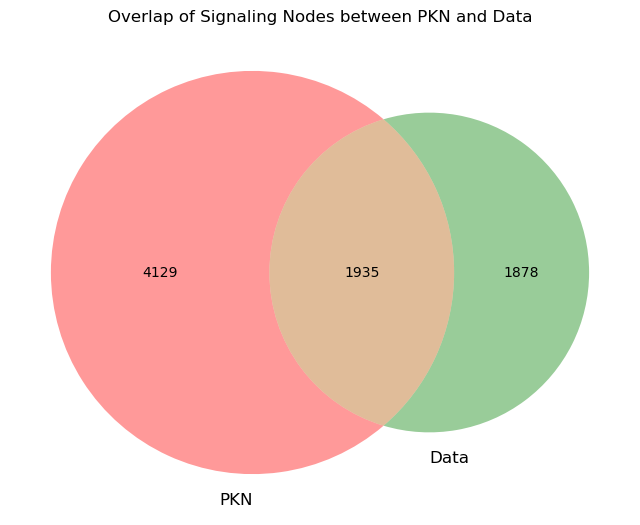

In [ ]:
net = pd.read_csv('../data/pkn_signaling.tsv', sep = '\t', index_col = False)
proteins_net = pd.concat([net['source'], net['target']], ignore_index=True).unique().tolist()
print("Number of unique proteins in net:", len(proteins_net))

proteins_map = map_protein['protein_id'].unique().tolist()
print("Number of unique protein_ids in map_protei:", len(proteins_map))

set_net = set(proteins_net)
set_map = set(proteins_map)

plt.figure(figsize=(8, 8))
venn_diagram = venn2([set_net, set_map], set_labels=('PKN', 'Data'))
plt.title("Overlap of Signaling Nodes between PKN and Data")
plt.show()

In [ ]:
# Filter out proteins that are not in the PKN from map_protein
map_protein = map_protein[map_protein['protein_id'].isin(set_net)]
print("Filtered map_protein shape:", map_protein.shape)

# Filter also the corresponding phosphosites
valid_site_ids = map_protein['site_id'].unique().tolist()
print("Number of valid site_ids in filtered map_protein:", len(valid_site_ids))

phospho_data = phospho_data[phospho_data['site_id'].isin(valid_site_ids)]
print("Filtered phospho_data shape:", phospho_data.shape)

Filtered map_protein shape: (8057, 7)
Number of valid site_ids in filtered map_protein: 8057
Filtered phospho_data shape: (2093312, 5)


Handle technical replicates by taking the median of the measurements.

In [ ]:
phospho_data = (
    phospho_data
    .groupby(["site_id", "Cell_line", "Drug", "Time"], as_index=False)
    .median()
)

phospho_data.head()

,site_id,Cell_line,Drug,Time,peptide_intensity
0,AAK1:Q2M2I8:S624,H508,AL,60,2.349995
1,AAK1:Q2M2I8:S624,H508,AL,1440,2.565329
2,AAK1:Q2M2I8:S624,H508,C,15,2.402596
3,AAK1:Q2M2I8:S624,H508,C,360,2.298490
4,AAK1:Q2M2I8:S624,H508,IM,5,2.606416


Visualize the phosphosites time-series of the drug targets across drugs and cell lines.

{'AL': [], 'C': ['P00519', 'P36507'], 'OS': ['P00533'], 'LI': [], 'WI': ['Q9NQB0', 'P35222'], 'RA': ['Q16539'], 'IM': ['P00519'], 'TR': ['P36507']}
Drug AL has empty target list; skipping subset creation.
Drug LI has empty target list; skipping subset creation.


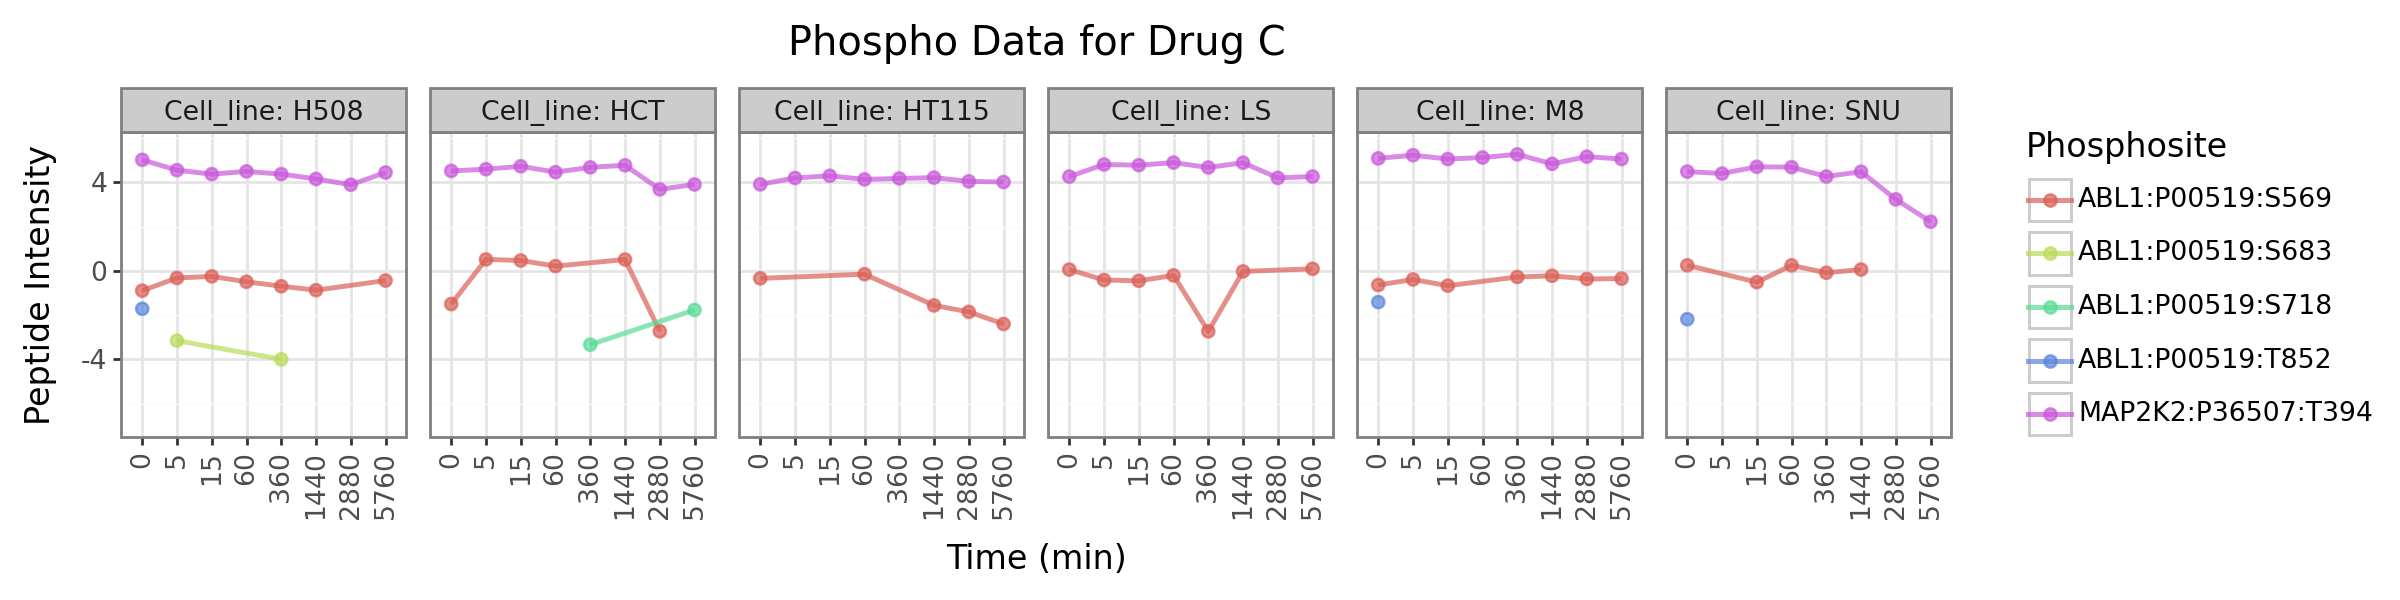

c:\Users\kanto\anaconda3\envs\deeplearning\Lib\site-packages\plotnine\geoms\geom_path.py:113: PlotnineWarning: geom_path: Each group consist of only one observation. Do you need to adjust the group aesthetic?


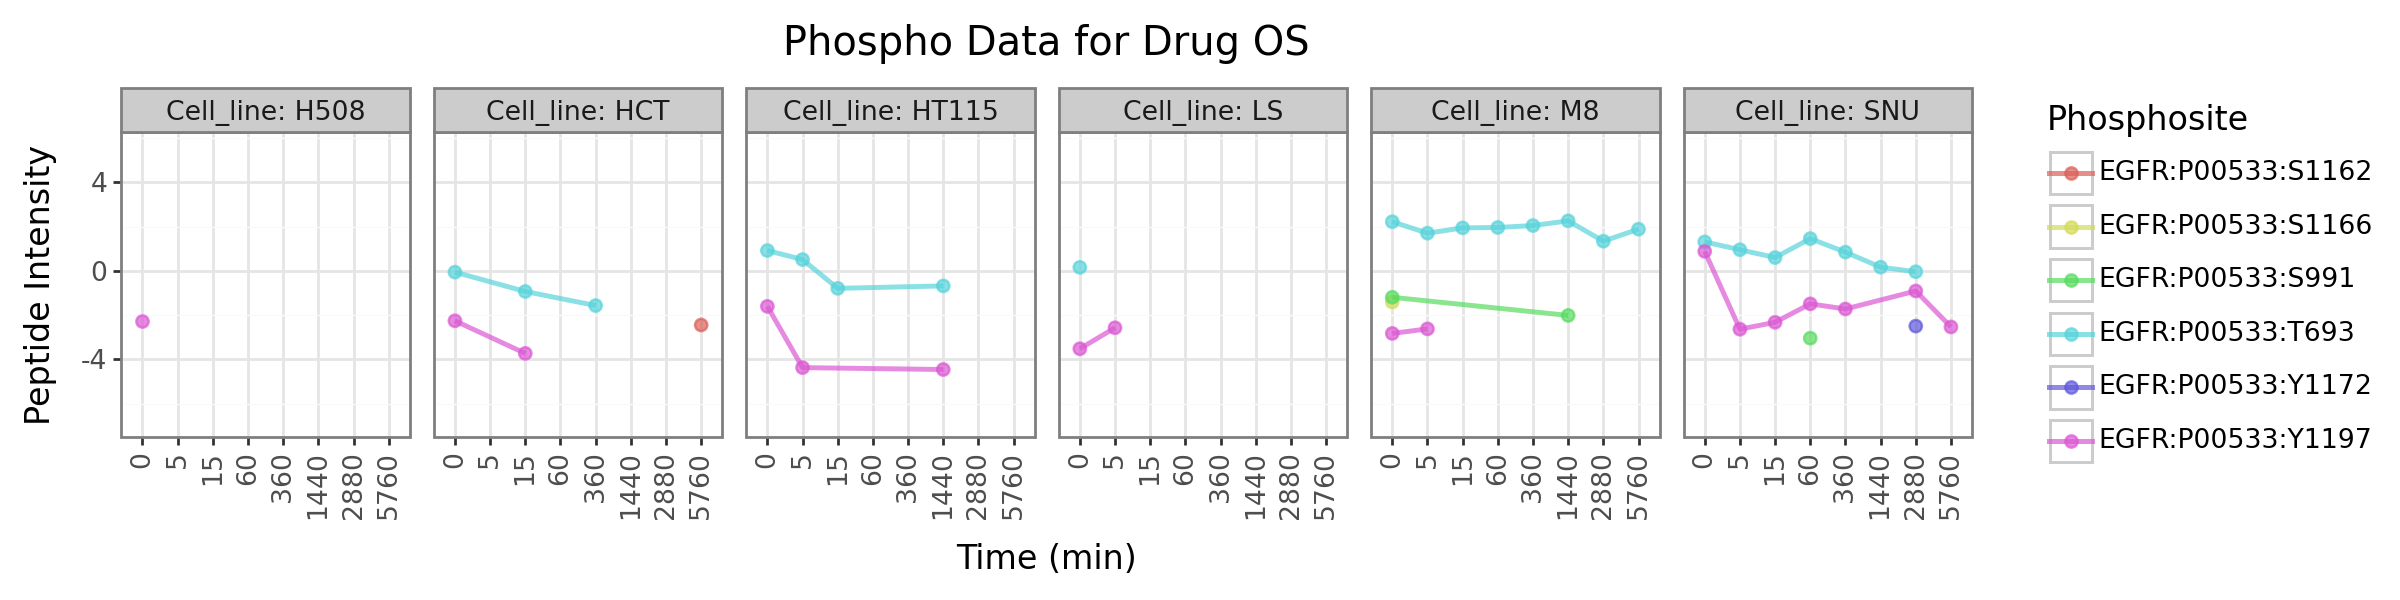

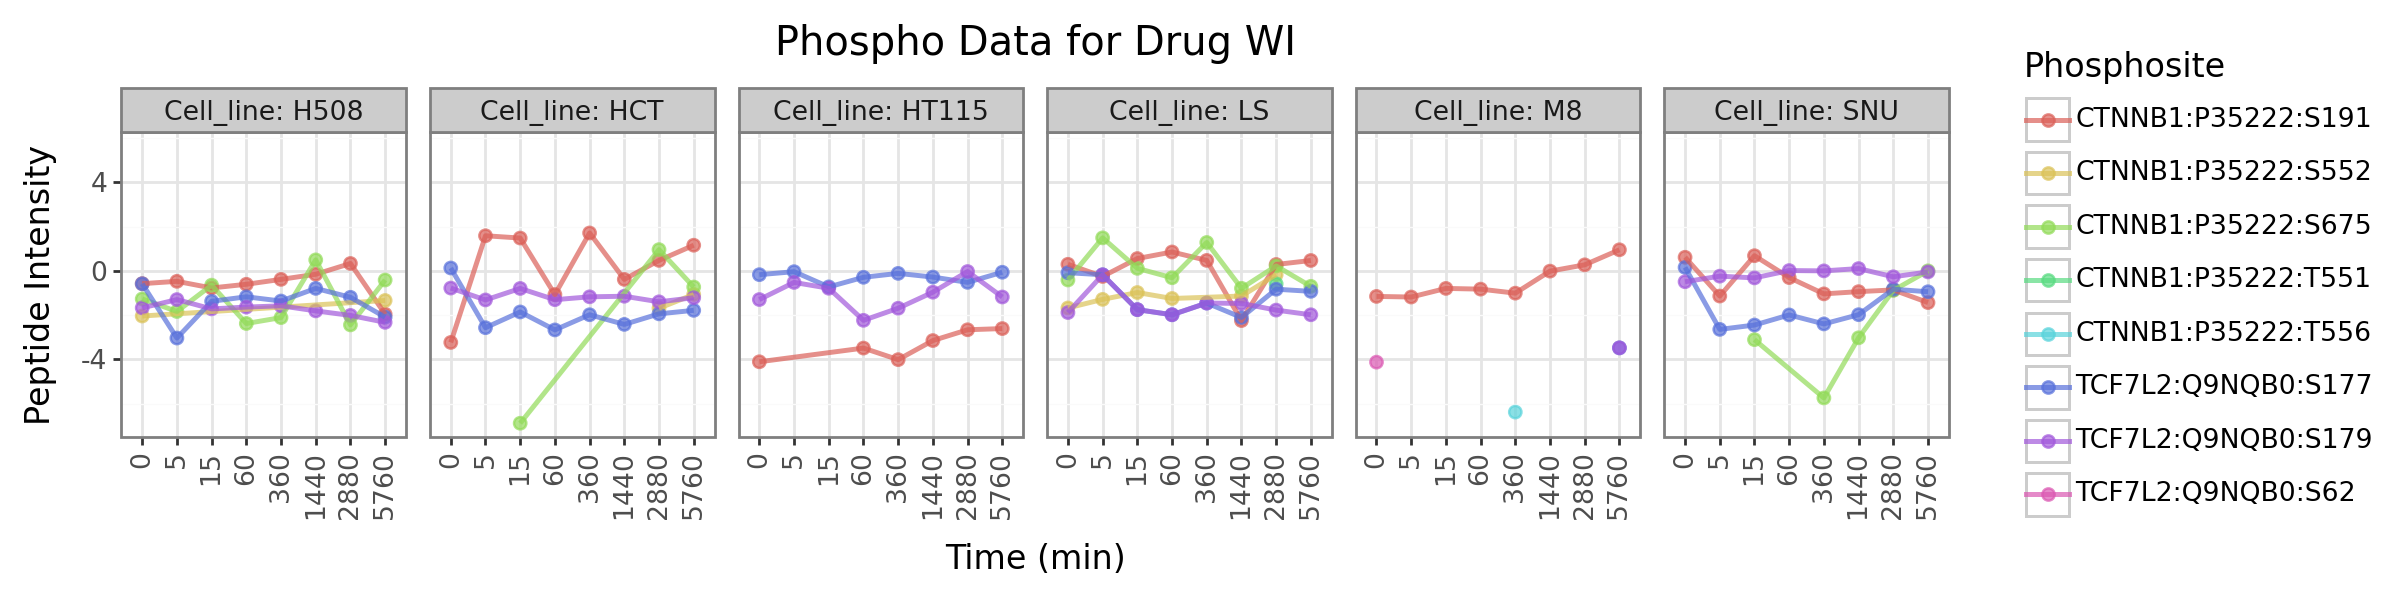

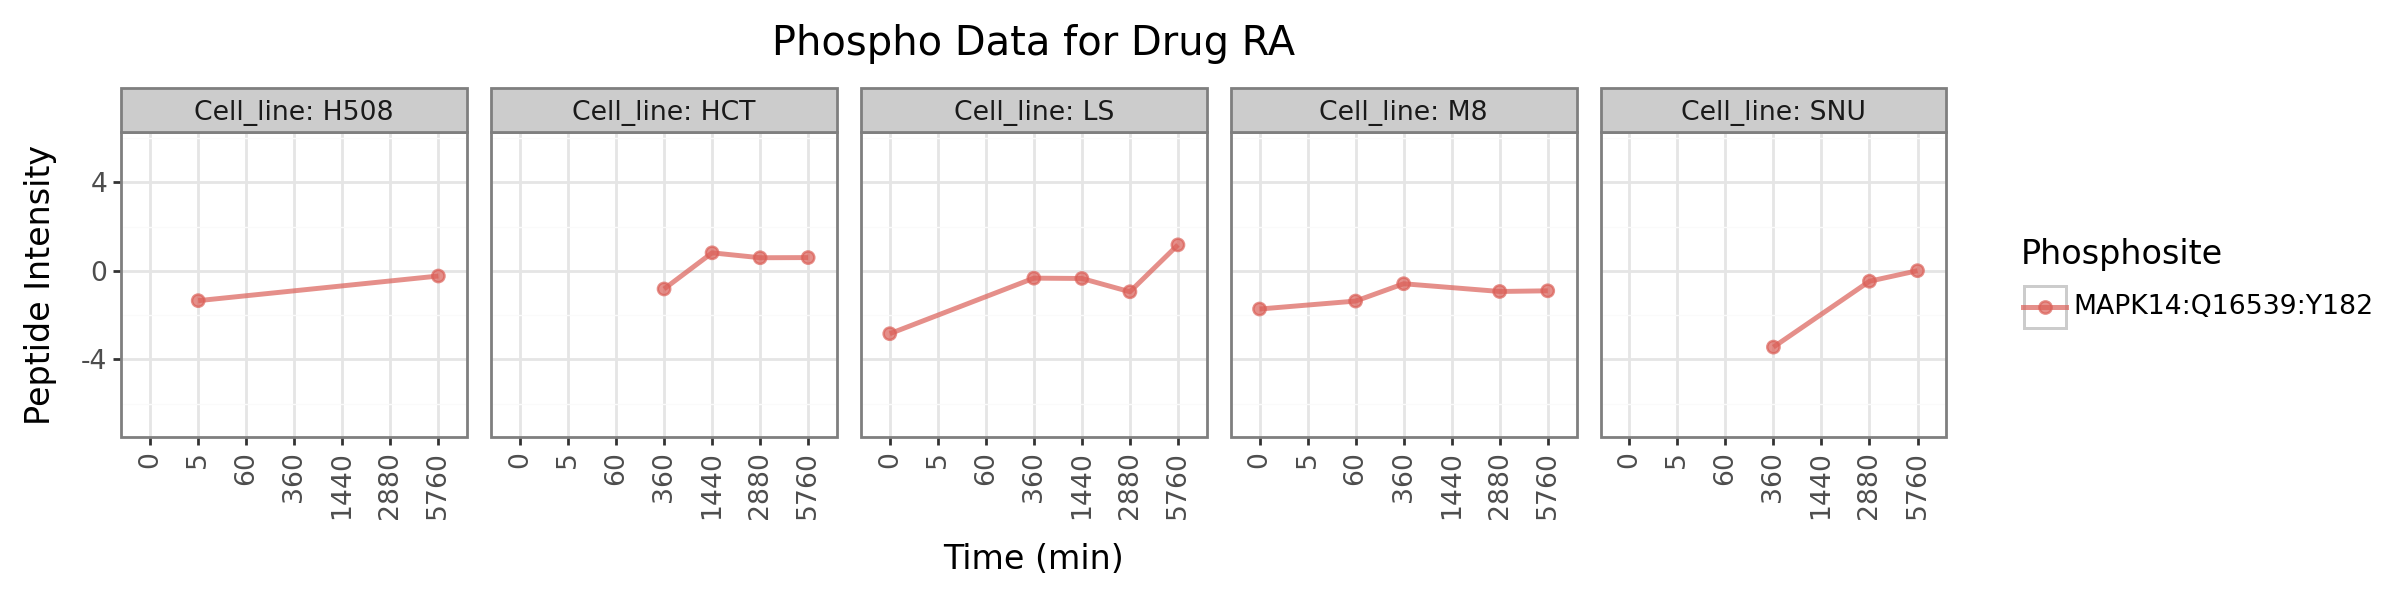

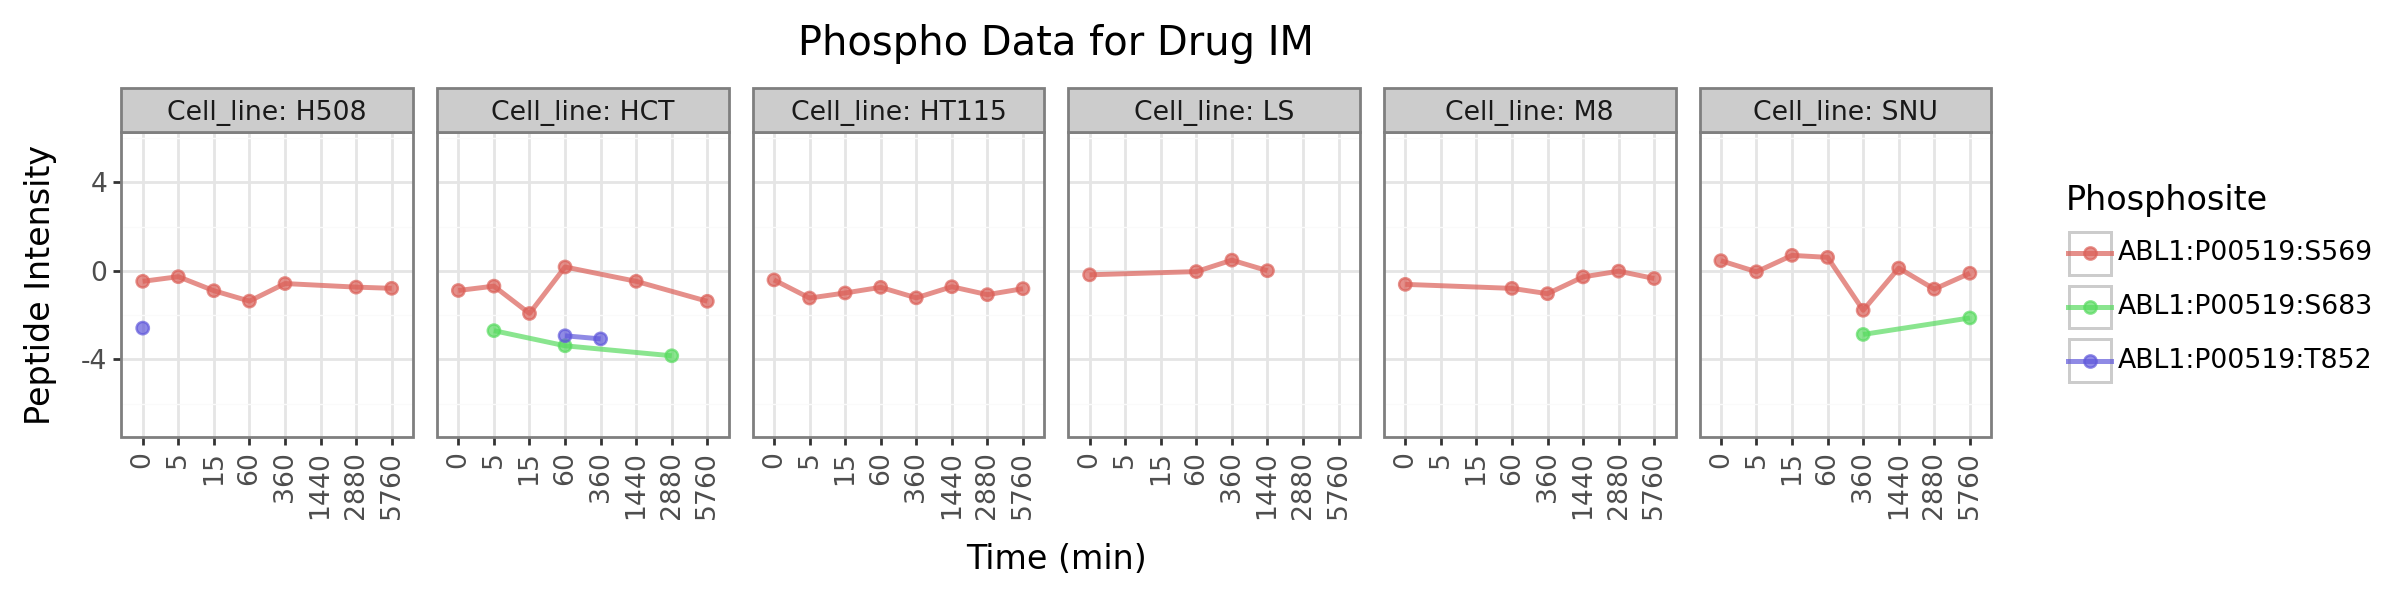

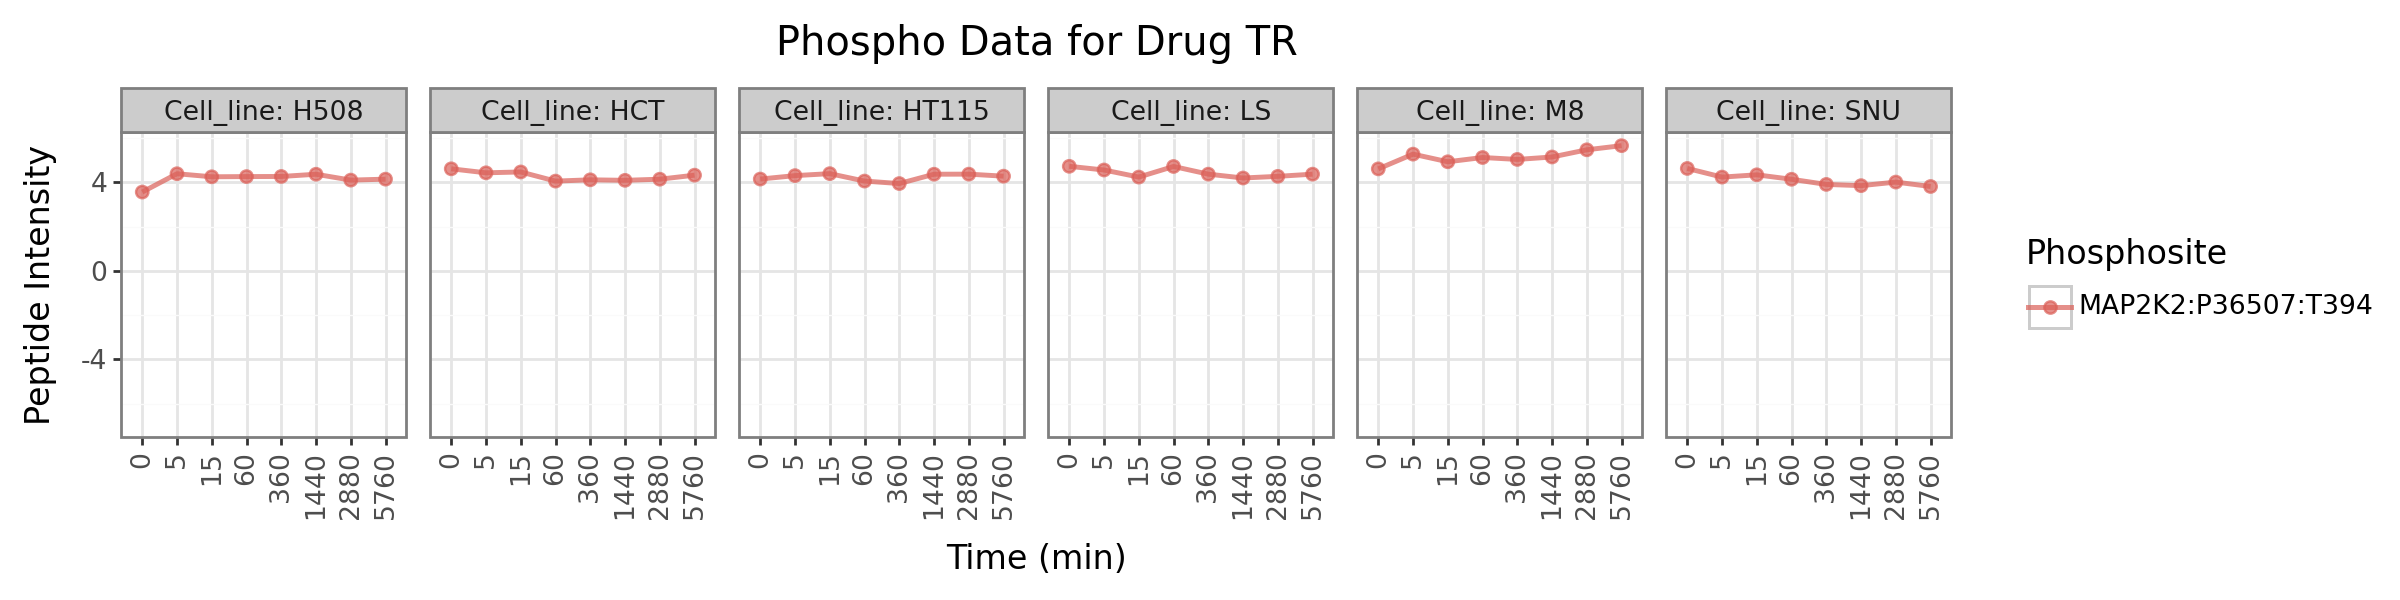

In [ ]:
drug_target = {
    'AL': ['P42336'], 
    'C': ['P00519', 'P36507'],  # selected ALB1 and MAP2K2 for reference
    'OS': ['P00533'],
    'LI': ['P08069', 'P06213'],
    'WI': ['Q9NQB0', 'P35222'], 
    'RA': ['Q16539', 'Q15759'], 
    'IM': ['P00519', 'P10721', 'P16234', 'P09619'],
    'TR': ['Q02750', 'P36507']
}

valid_proteins = set(map_protein['protein_id'].unique())

filtered_drug_target = {}
for drug, proteins in drug_target.items():
    filtered = [p for p in proteins if p in valid_proteins]
    filtered_drug_target[drug] = filtered
print(filtered_drug_target)

# --- Build a separate dataset for each drug ---
drug_plot_dfs = {}

for drug, protein_ids in filtered_drug_target.items():
    if protein_ids:
        # Get all site_ids from map_protein that map to the drug's target proteins.
        valid_sites = map_protein.loc[map_protein['protein_id'].isin(protein_ids), 'site_id'].unique().tolist()
        if valid_sites:
            # Subset phospho_data only by valid site_ids, and then filter the Drug column.
            drug_phospho = phospho_data[(phospho_data['site_id'].isin(valid_sites)) & (phospho_data['Drug'] == drug)].copy()
            # Create an ordered categorical variable for Time.
            time_order = sorted(drug_phospho['Time'].unique(), key=lambda x: float(x))
            drug_phospho['Time_factor'] = pd.Categorical(drug_phospho['Time'], categories=time_order, ordered=True)
            drug_plot_dfs[drug] = drug_phospho
    else:
        print(f"Drug {drug} has empty target list; skipping subset creation.")

if drug_plot_dfs:
    all_pep_data = pd.concat(drug_plot_dfs.values())
    global_ymin = all_pep_data['peptide_intensity'].min()
    global_ymax = all_pep_data['peptide_intensity'].max()
else:
    global_ymin, global_ymax = None, None

for drug, df_drug in drug_plot_dfs.items():
    p = (
        p9.ggplot(df_drug, p9.aes(x='Time_factor', y='peptide_intensity', color='site_id'))
        + p9.geom_point(size=2, alpha=0.7)
        + p9.geom_line(p9.aes(group='site_id'), size=1, alpha=0.7)
        + p9.facet_wrap('~Cell_line', nrow=1, labeller='label_both')
        + p9.labs(title=f"Phospho Data for Drug {drug}",
                  x="Time (min)",
                  y="Peptide Intensity",
                  color="Phosphosite")
        + p9.scale_y_continuous(limits=[global_ymin, global_ymax])
        + p9.theme_bw(base_size=12)
        + p9.theme(figure_size=(12,3),
                   axis_text_x=p9.element_text(angle=90, vjust=1, hjust=0.5))
    )
    p.show()

Widen the data to have phosphosites as columns and samples as rows.

In [ ]:
phospho_data_wide = phospho_data.pivot_table(index=['Cell_line', 'Drug', 'Time'], columns='site_id', values='peptide_intensity')
phospho_data_wide = phospho_data_wide.reset_index()

print(phospho_data_wide.shape)
display(phospho_data_wide.head())

(384, 8060)


site_id,Cell_line,Drug,Time,AAK1:Q2M2I8:S624,AAK1:Q2M2I8:S637,AAK1:Q2M2I8:S676,AAK1:Q2M2I8:S678,AAK1:Q2M2I8:T389,AAK1:Q2M2I8:T606,AAK1:Q2M2I8:T620,...,ZRSR2:Q15696:S349,ZRSR2:Q15696:S384,ZYX:Q15942:S259,ZYX:Q15942:S267,ZYX:Q15942:S281,ZYX:Q15942:S308,ZYX:Q15942:S344,ZYX:Q15942:T159,ZYX:Q15942:T270,ZYX:Q15942:T274
0,H508,AL,0,NaN,0.323331,NaN,NaN,-1.341094,1.922543,NaN,...,0.440325,NaN,3.619476,-0.058059,2.233695,NaN,1.752667,NaN,-2.154725,-0.896373
1,H508,AL,5,NaN,1.623195,NaN,NaN,NaN,0.677912,NaN,...,0.734832,-2.521227,3.366211,-0.740823,0.349371,NaN,1.015650,NaN,-2.631489,-3.495737
2,H508,AL,15,NaN,1.386295,NaN,NaN,-2.822999,-0.151421,NaN,...,1.201390,-2.494938,3.216104,-0.633042,0.445755,NaN,0.449308,NaN,-2.497215,-3.598141
3,H508,AL,60,2.349995,0.072145,NaN,NaN,NaN,0.697043,2.349995,...,1.288375,-2.340314,3.280711,-0.260487,0.829271,NaN,1.291104,NaN,-1.971568,-2.596486
4,H508,AL,360,NaN,1.637429,NaN,-0.580961,-2.396530,0.719716,NaN,...,1.164106,-2.191169,3.250271,-0.261424,0.701760,NaN,0.948047,NaN,-2.044746,-2.952332


First of all, we should check the missing value percentages across samples and across phosphosites.

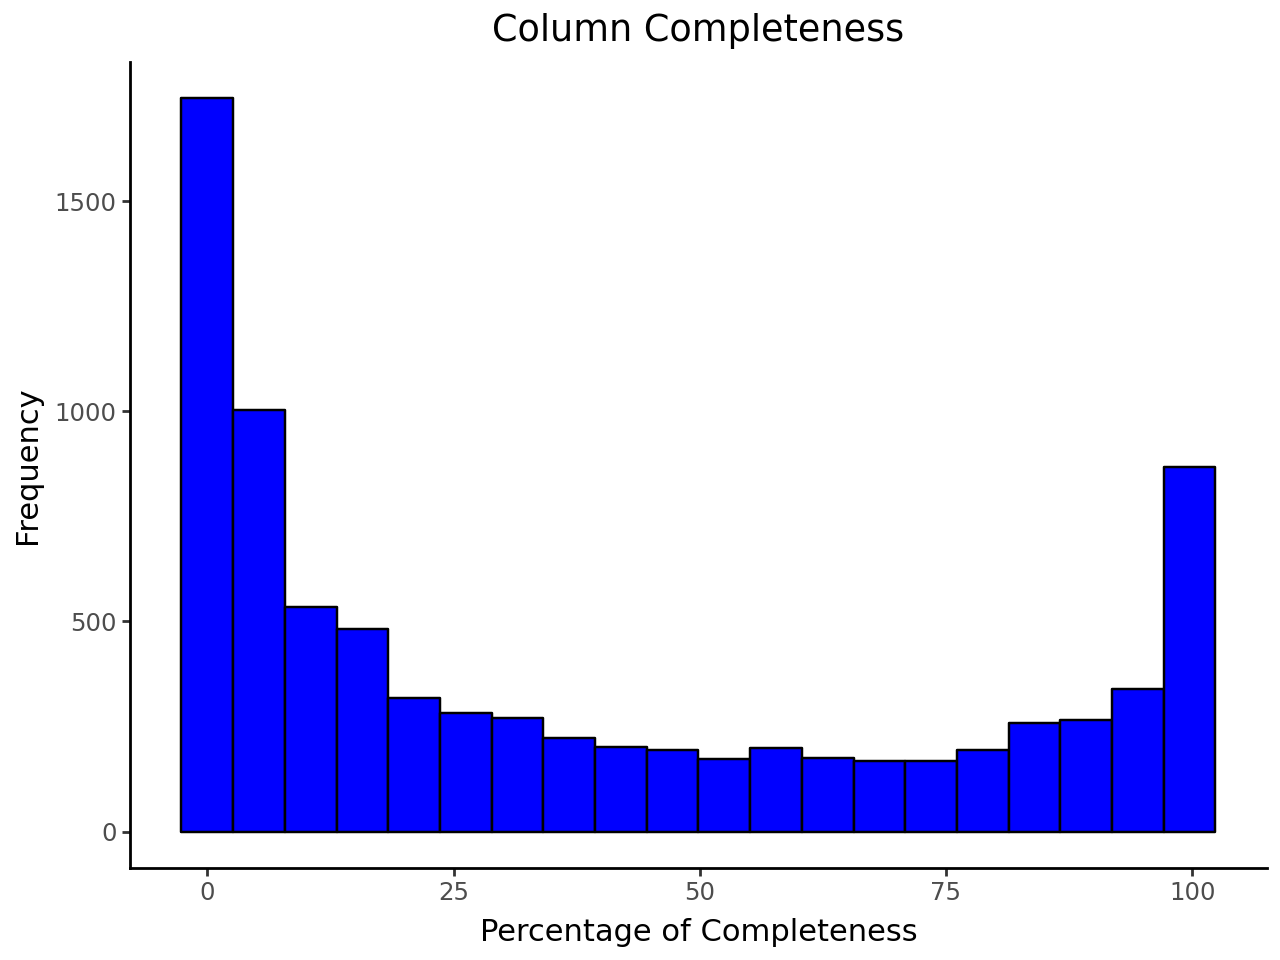

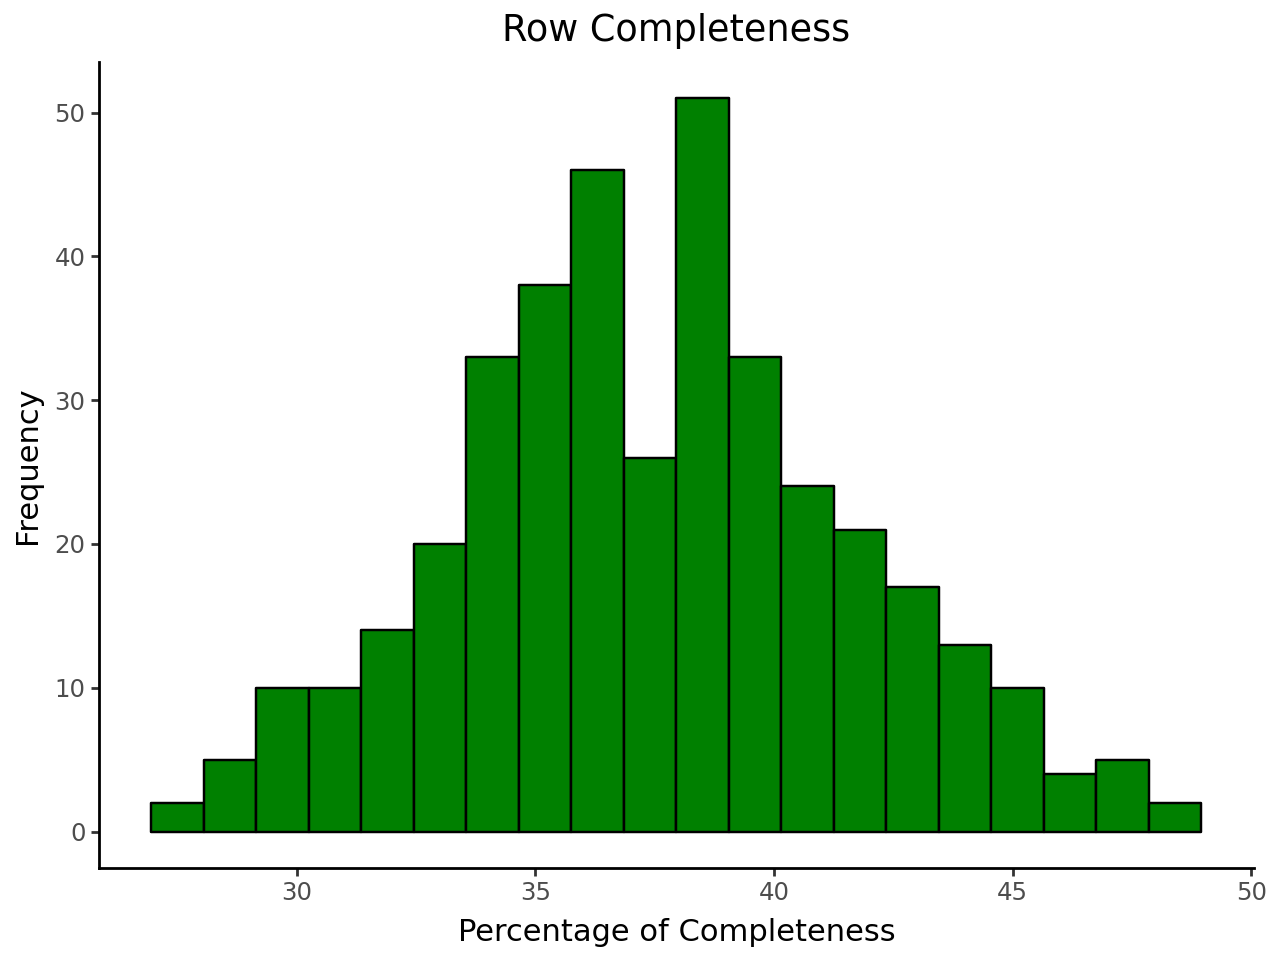

In [ ]:
# Calculate the percentage of completeness across rows and columns (excluding Cell_line, Drug, and Time)
column_completeness = phospho_data_wide.drop(columns=['Cell_line', 'Drug', 'Time']).notna().mean() * 100
row_completeness = phospho_data_wide.drop(columns=['Cell_line', 'Drug', 'Time']).notna().mean(axis=1) * 100

column_completeness_df = pd.DataFrame({'Completeness': column_completeness})
row_completeness_df = pd.DataFrame({'Completeness': row_completeness})

# Histogram for column completeness
p1 = (p9.ggplot(column_completeness_df, p9.aes(x='Completeness')) +
      p9.geom_histogram(bins=20, fill='blue', color='black') +
      p9.labs(title='Column Completeness',
           x='Percentage of Completeness',
           y='Frequency') +
      p9.theme_classic())

# Histogram for row completeness
p2 = (p9.ggplot(row_completeness_df, p9.aes(x='Completeness')) +
      p9.geom_histogram(bins=20, fill='green', color='black') +
      p9.labs(title='Row Completeness',
           x='Percentage of Completeness',
           y='Frequency') +
      p9.theme_classic())

p1.show()
p2.show()

Let's also visualize the completeness percentage but for different experiment metadata combinations across time as a heatmap to check for any clear patterns.

<Figure size 1200x800 with 0 Axes>

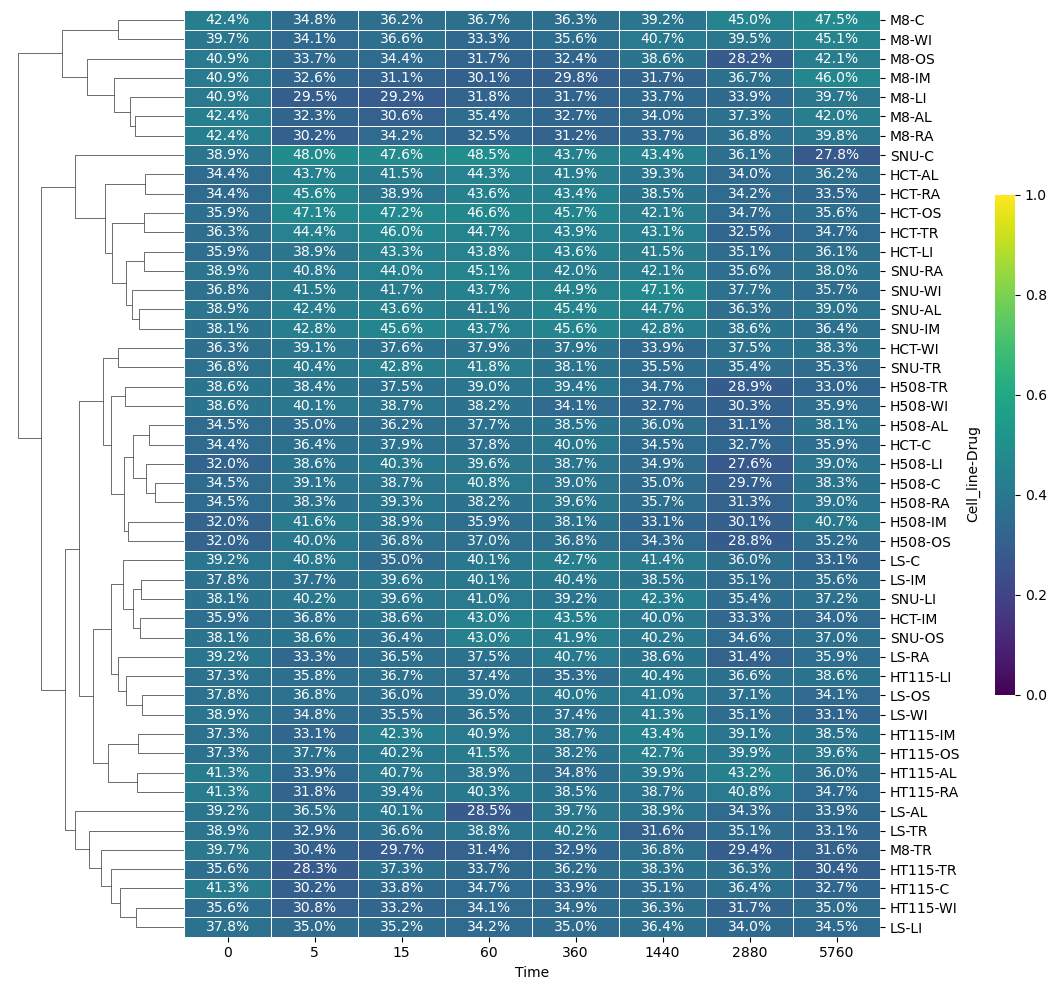

In [ ]:
phospho_data_long = phospho_data_wide.melt(id_vars=['Cell_line', 'Drug', 'Time'], 
                                           var_name='site_name', 
                                           value_name='peptide_intensity')
phospho_data_long['is_complete'] = phospho_data_long['peptide_intensity'].notna().astype(int)
completeness = phospho_data_long.groupby(['Cell_line', 'Drug', 'Time'])['is_complete'].mean().reset_index()
completeness_pivot = completeness.pivot_table(index=['Cell_line', 'Drug'], columns='Time', values='is_complete')

plt.figure(figsize=(12, 8))
sns.clustermap(completeness_pivot, 
               cmap='viridis', 
               annot=True, 
               fmt='.1%', 
               linewidths=.5, 
               vmin=0, 
               vmax=1, 
               col_cluster=False, 
               cbar_pos=(1, 0.3, .02, .5),
               dendrogram_ratio=(.2, 0))
plt.show()

Plot relations between proteins, peptides and phosphosites.

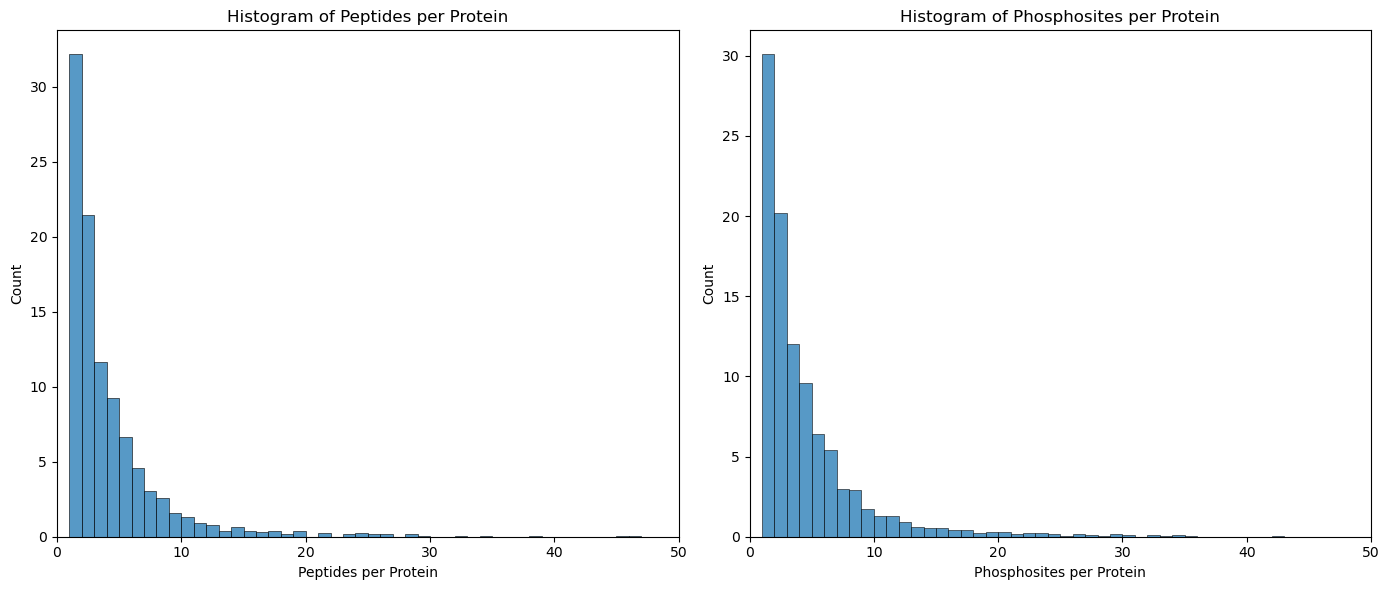

In [ ]:
protein_aggregates = map_protein.groupby('protein_id').agg(
    peptides_per_protein=('peptide_id', 'nunique'),
    phosphosites_per_protein=('phosphosite', 'nunique')
).reset_index()

# Plot histograms for peptides per protein and phosphosites per protein
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
sns.histplot(protein_aggregates['peptides_per_protein'], binwidth=1, stat='percent')
plt.title('Histogram of Peptides per Protein')
plt.xlabel('Peptides per Protein')
plt.ylabel('Count')
plt.xlim(0, 50)

plt.subplot(1, 2, 2)
sns.histplot(protein_aggregates['phosphosites_per_protein'], binwidth=1, stat='percent')
plt.title('Histogram of Phosphosites per Protein')
plt.xlabel('Phosphosites per Protein')
plt.ylabel('Count')
plt.xlim(0, 50)

plt.tight_layout()
plt.show()

Filter out phosphosites with less than 50% completeness, impute the data using KNN (k = 5) and run PCA to assess batch effects and outliers.

In [ ]:
# Exclude columns with less than 50% completeness
completeness_threshold = 50
column_completeness = phospho_data_wide.drop(columns=['Cell_line', 'Drug', 'Time']).notna().mean() * 100
columns_to_keep = column_completeness[column_completeness >= completeness_threshold].index
phospho_data_filtered = phospho_data_wide[['Cell_line', 'Drug', 'Time'] + list(columns_to_keep)]

# KNN impute with 5 neighbors
imputer = KNNImputer(n_neighbors=5)
phospho_data_imputed = phospho_data_filtered.copy()
phospho_data_imputed.iloc[:, 3:] = imputer.fit_transform(phospho_data_filtered.iloc[:, 3:])

# Run PCA
pca = PCA(n_components=2)
pca_results = pca.fit_transform(phospho_data_imputed.iloc[:, 3:])
pca_df = pd.DataFrame(pca_results, columns=['PC1', 'PC2'])
pca_df['Time'] = phospho_data_imputed['Time'].astype(str)
pca_df['Drug'] = phospho_data_imputed['Drug']
pca_df['Cell_line'] = phospho_data_imputed['Cell_line']

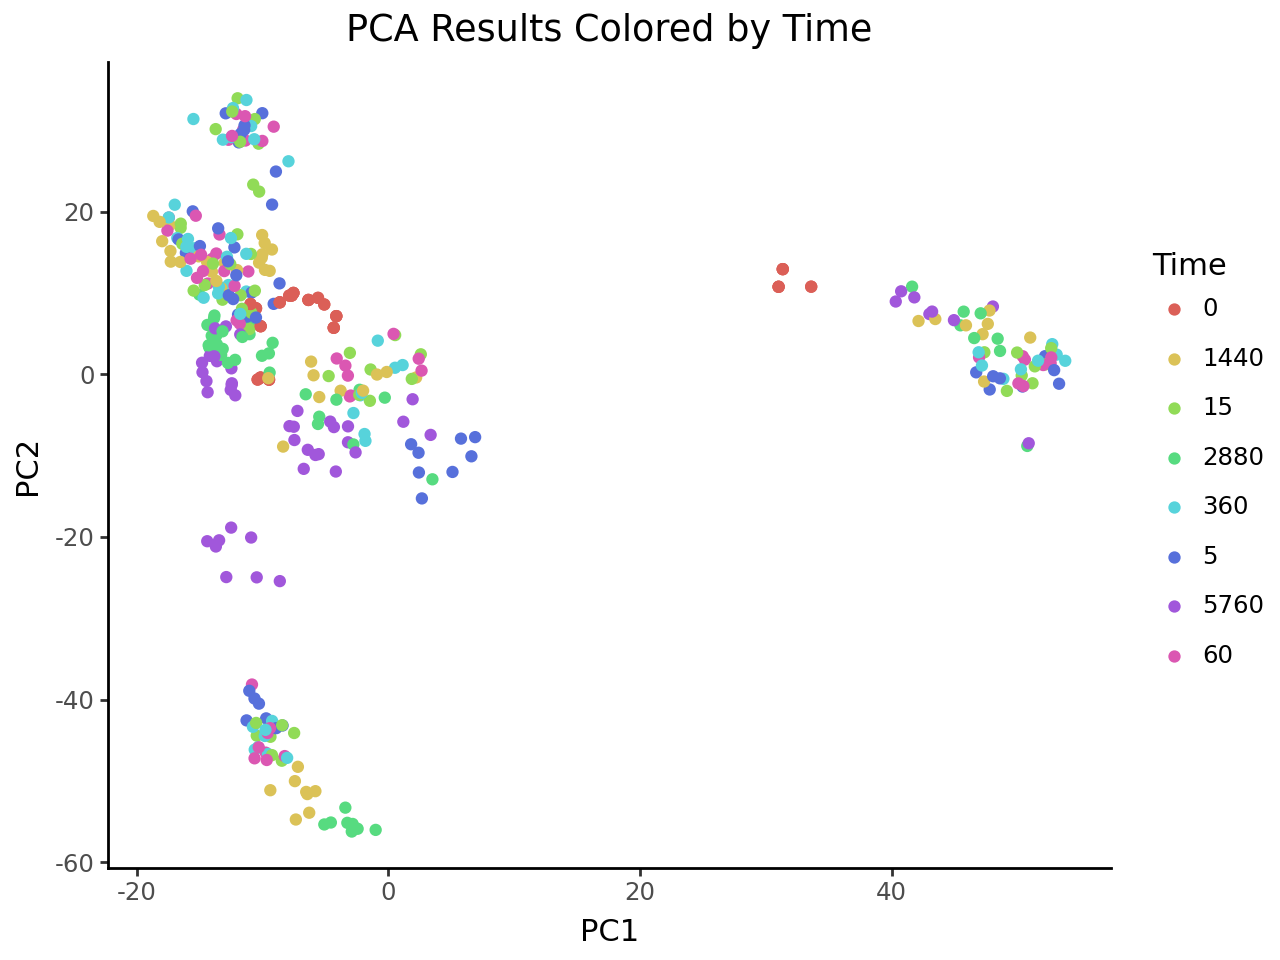

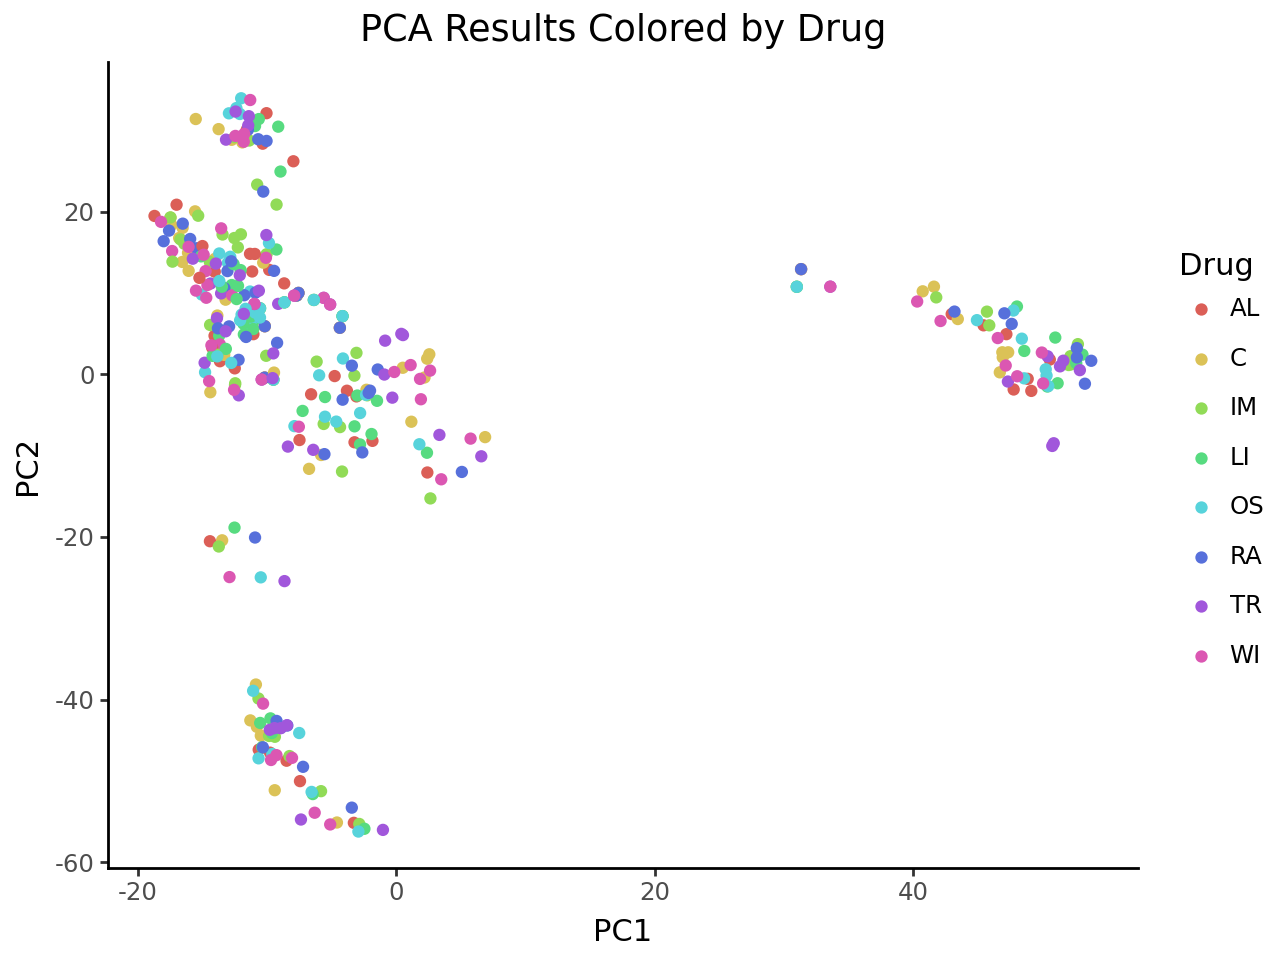

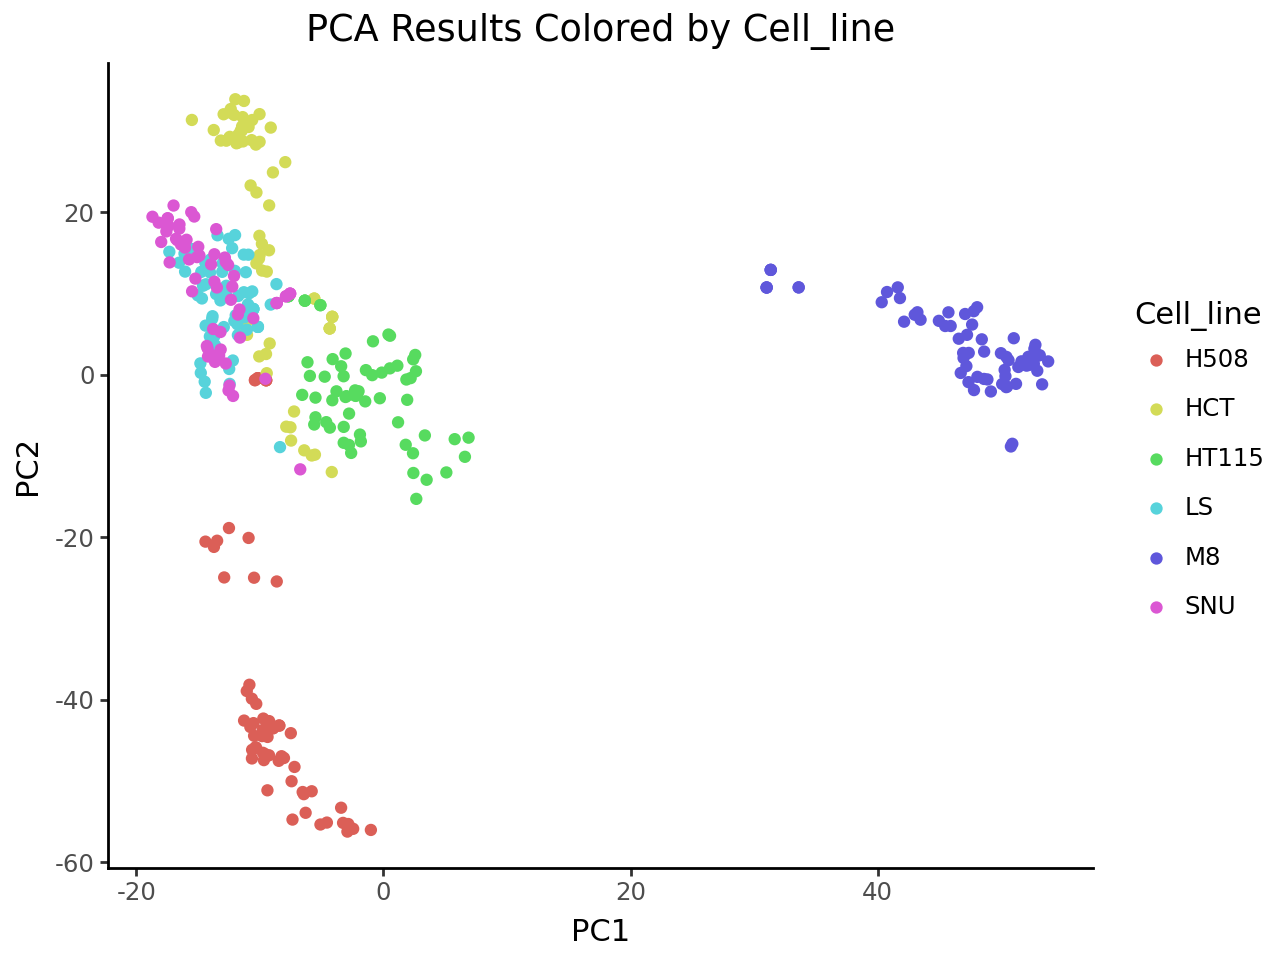

In [ ]:
# Color by Time
plot_time = (p9.ggplot(pca_df, p9.aes(x='PC1', y='PC2', color='Time')) +
             p9.geom_point() +
             p9.labs(title='PCA Results Colored by Time', x='PC1', y='PC2') +
             p9.theme_classic())
plot_time.show()

# Color by Drug
plot_drug = (p9.ggplot(pca_df, p9.aes(x='PC1', y='PC2', color='Drug')) +
             p9.geom_point() +
             p9.labs(title='PCA Results Colored by Drug', x='PC1', y='PC2') +
             p9.theme_classic())
plot_drug.show()

# Color by Cell_line
plot_cell_line = (p9.ggplot(pca_df, p9.aes(x='PC1', y='PC2', color='Cell_line')) +
                  p9.geom_point() +
                  p9.labs(title='PCA Results Colored by Cell_line', x='PC1', y='PC2') +
                  p9.theme_classic())
plot_cell_line.show()

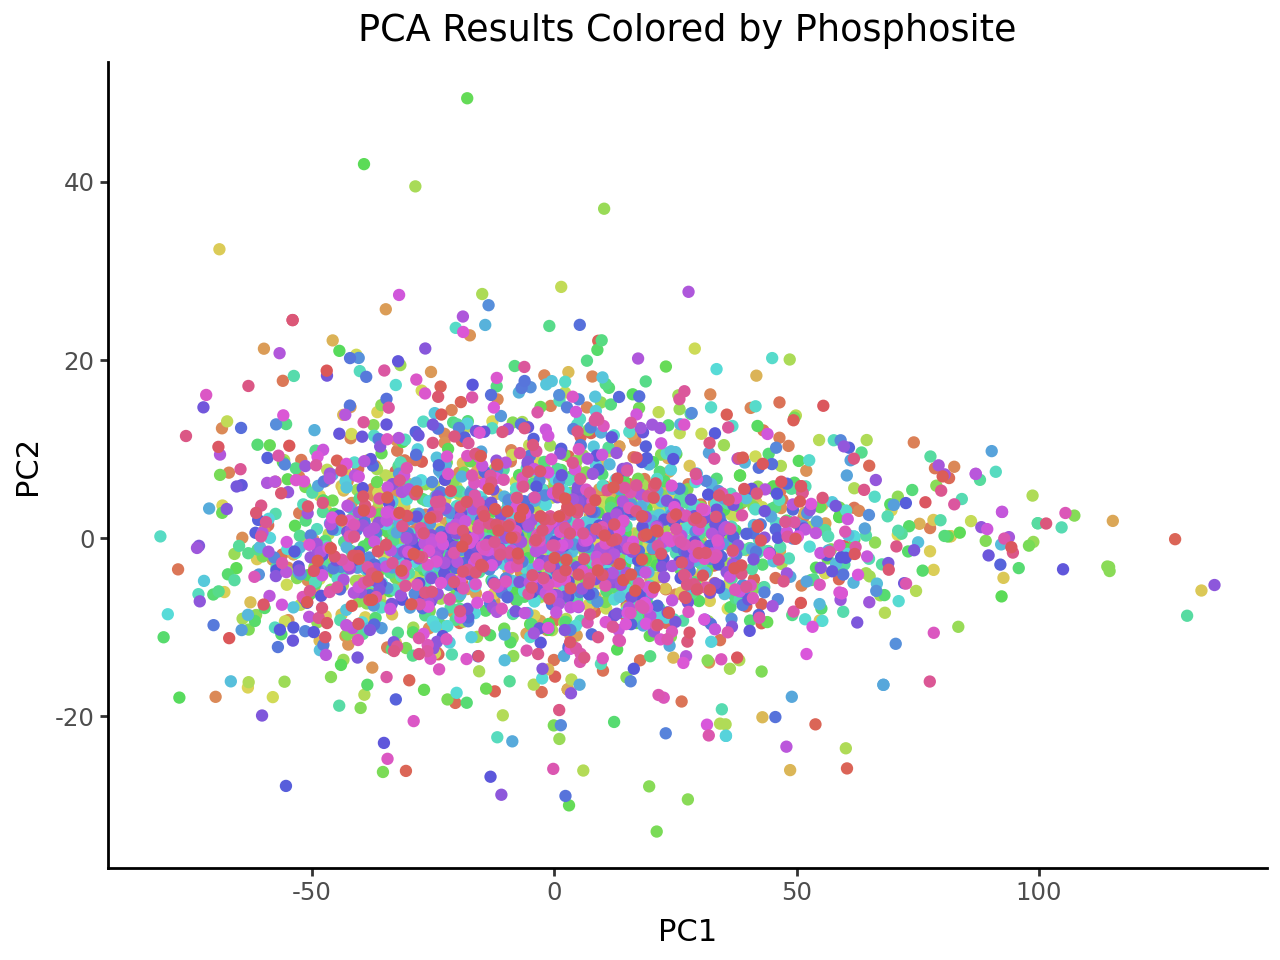

In [ ]:
phospho_data_transformed = phospho_data_imputed.drop(columns=['Cell_line', 'Drug', 'Time'])

# Run PCA on the transformed dataframe
pca_transformed = PCA(n_components=2)
pca_results_transformed = pca_transformed.fit_transform(phospho_data_transformed.T)
pca_df_transformed = pd.DataFrame(pca_results_transformed, columns=['PC1', 'PC2'])
pca_df_transformed['Phosphosite'] = phospho_data_transformed.columns

# Plot PCA results colored by Phosphosite
plot_phosphosite = (p9.ggplot(pca_df_transformed, p9.aes(x='PC1', y='PC2', color='Phosphosite')) +
                    p9.geom_point() +
                    p9.labs(title='PCA Results Colored by Phosphosite', x='PC1', y='PC2') +
                    p9.theme_classic() + 
                    p9.theme(legend_position='none'))
plot_phosphosite.show()

## Prepare Data for Modeling

Based on the phospho_data create the input datasets `X`, `X_drug` and `X_cell` as well as the target dataset `y`. Based on the map_protein create the nodes_sites_map dataset.

In [ ]:
# Create dictionaries with the drug doses and drug targets
#drug_dose = {'AL': 0.12, 'C': 0, 'OS': 0.5, 'LI': 0.14, 'WI': 0.5, 'RA': 0.5, 'IM': 0.5, 'TR': 0.036}
drug_dose = {'AL': 1, 'C': 0, 'OS': 1, 'LI': 1, 'WI': 1, 'RA': 1, 'IM': 1, 'TR': 1}  # one-hot encoded as we don't have multiple doses
cell_lines = phospho_data['Cell_line'].unique()
drug_dose = {(drug, cell_line): dose for drug, dose in drug_dose.items() for cell_line in cell_lines}  # same drug concentration for all cell lines

drug_target = {
    'AL': ['P42336'], 
    'C': [],
    'OS': ['P00533'],
    'LI': ['P08069', 'P06213'],
    'WI': ['Q9NQB0', 'P35222'], 
    'RA': ['Q16539', 'Q15759'], 
    'IM': ['P00519', 'P10721', 'P16234', 'P09619'],
    'TR': ['Q02750', 'P36507']
}


# Prepare X_data
unique_drug_cell_line = phospho_data[['Drug', 'Cell_line']].drop_duplicates().sort_values(by=['Drug', 'Cell_line'])
multiindex = pd.MultiIndex.from_frame(unique_drug_cell_line)
X_data = pd.DataFrame(index=multiindex)

unique_drugs = phospho_data['Drug'].unique()
for drug in unique_drugs:
    X_data[drug] = 0.0

for (drug, cell_line), dose in drug_dose.items():
    if (drug, cell_line) in X_data.index:
        X_data.loc[(drug, cell_line), drug] = dose

X_data.index = X_data.index.map('_'.join)
X_data.index.name = 'Drug_CL'

# Prepare X_drug
unique_targets = sorted(set(target for targets in drug_target.values() for target in targets))
X_drug = pd.DataFrame(0, index=unique_targets, columns=unique_drugs)

for drug, targets in drug_target.items():
    for target in targets:
        if target in X_drug.index:
            X_drug.loc[target, drug] = 1


# Prepare X_cell
X_cell = pd.DataFrame(index=multiindex)

unique_cell_lines = phospho_data['Cell_line'].unique()
for cell_line in unique_cell_lines:
    X_cell[cell_line] = 0

for drug, cell_line in unique_drug_cell_line.itertuples(index=False):
    X_cell.loc[(drug, cell_line), cell_line] = 1

X_cell.index = X_cell.index.map('_'.join)
X_cell.index.name = 'Drug_CL'


# Prepare y_data
y_data = phospho_data.pivot_table(index=['Drug', 'Cell_line', 'Time'], columns='site_id', values='peptide_intensity')
y_data.reset_index(inplace=True)
y_data['Drug_CL_Time'] = y_data[['Drug', 'Cell_line', 'Time']].astype(str).agg('_'.join, axis=1)
y_data.set_index('Drug_CL_Time', inplace=True)
y_data.drop(columns=['Drug', 'Cell_line', 'Time'], inplace=True)


# Prepare nodes_sites_map
unique_proteins = map_protein['protein_id'].unique()
unique_sites = map_protein['site_id'].unique()

nodes_sites_map = pd.DataFrame(0, index=unique_sites, columns=unique_proteins)

for _, row in map_protein.iterrows():
    site = row['site_id']
    protein = row['protein_id']
    if site in nodes_sites_map.index and protein in nodes_sites_map.columns:
        nodes_sites_map.loc[site, protein] = 1

# Sort and match index of nodes_sites_map with y_data
nodes_sites_map = nodes_sites_map.sort_index()
non_overlapping_values = set(nodes_sites_map.index).difference(y_data.columns)
nodes_sites_map = nodes_sites_map.drop(index=non_overlapping_values)

display(X_data.head())
print(X_data.shape)

display(X_drug.head())
print(X_drug.shape)

display(X_cell.head())
print(X_cell.shape)

display(y_data.head())
print(y_data.shape)

display(nodes_sites_map.head())
print(nodes_sites_map.shape)

,AL,C,IM,LI,OS,RA,TR,WI
Drug_CL,,,,,,,,
AL_H508,0.12,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AL_HCT,0.12,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AL_HT115,0.12,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AL_LS,0.12,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AL_M8,0.12,0.0,0.0,0.0,0.0,0.0,0.0,0.0


(48, 8)


,AL,C,IM,LI,OS,RA,TR,WI
P00519,0,0,1,0,0,0,0,0
P00533,0,0,0,0,1,0,0,0
P06213,0,0,0,1,0,0,0,0
P08069,0,0,0,1,0,0,0,0
P09619,0,0,1,0,0,0,0,0


(14, 8)


,H508,HCT,HT115,LS,M8,SNU
Drug_CL,,,,,,
AL_H508,1,0,0,0,0,0
AL_HCT,0,1,0,0,0,0
AL_HT115,0,0,1,0,0,0
AL_LS,0,0,0,1,0,0
AL_M8,0,0,0,0,1,0


(48, 6)


site_id,AAK1:Q2M2I8:S624,AAK1:Q2M2I8:S637,AAK1:Q2M2I8:S676,AAK1:Q2M2I8:S678,AAK1:Q2M2I8:T389,AAK1:Q2M2I8:T606,AAK1:Q2M2I8:T620,AAK1:Q2M2I8:T674,AATF:Q9NY61:S203,AATF:Q9NY61:S316,...,ZRSR2:Q15696:S349,ZRSR2:Q15696:S384,ZYX:Q15942:S259,ZYX:Q15942:S267,ZYX:Q15942:S281,ZYX:Q15942:S308,ZYX:Q15942:S344,ZYX:Q15942:T159,ZYX:Q15942:T270,ZYX:Q15942:T274
Drug_CL_Time,,,,,,,,,,,,,,,,,,,,,
AL_H508_0,NaN,0.323331,NaN,NaN,-1.341094,1.922543,NaN,NaN,-1.191584,NaN,...,0.440325,NaN,3.619476,-0.058059,2.233695,NaN,1.752667,NaN,-2.154725,-0.896373
AL_H508_5,NaN,1.623195,NaN,NaN,NaN,0.677912,NaN,NaN,-0.519022,NaN,...,0.734832,-2.521227,3.366211,-0.740823,0.349371,NaN,1.015650,NaN,-2.631489,-3.495737
AL_H508_15,NaN,1.386295,NaN,NaN,-2.822999,-0.151421,NaN,NaN,-1.912694,NaN,...,1.201390,-2.494938,3.216104,-0.633042,0.445755,NaN,0.449308,NaN,-2.497215,-3.598141
AL_H508_60,2.349995,0.072145,NaN,NaN,NaN,0.697043,2.349995,NaN,-0.247923,NaN,...,1.288375,-2.340314,3.280711,-0.260487,0.829271,NaN,1.291104,NaN,-1.971568,-2.596486
AL_H508_360,NaN,1.637429,NaN,-0.580961,-2.396530,0.719716,NaN,NaN,0.293281,NaN,...,1.164106,-2.191169,3.250271,-0.261424,0.701760,NaN,0.948047,NaN,-2.044746,-2.952332


(384, 8057)


,Q96S94,O75822,Q01167,Q13523,P62877,Q12933,P30566,Q99959,Q9H7Z6,Q13263,...,Q16629,O60506,P08559,P62136,P53675,P30307,P62140,Q9NQZ2,Q9UH99,Q99426
AAK1:Q2M2I8:S624,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
AAK1:Q2M2I8:S637,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
AAK1:Q2M2I8:S676,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
AAK1:Q2M2I8:S678,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
AAK1:Q2M2I8:T389,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


(8057, 1935)


## Export Data

In [ ]:
y_data.to_csv('../data/vespa_y.csv', index=True)
X_data.to_csv('../data/vespa_x.csv', index=True)
X_cell.to_csv('../data/vespa_xcell.csv', index=True)
X_drug.to_csv('../data/vespa_xdrug.csv', index=True)
nodes_sites_map.to_csv('../data/vespa_nodes_sites_map.csv', index=True)